# Data in PyTorch

PyTorch has two main classes that deal with data, `Dataset` and `Dataloader`.

A `Dataloader` is a generator that returns parts of a `Dataset` and helps with things like batching

In [1]:
import torch
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

## Dataset must implement `__len__` and `__getitem__`

In [2]:
import numpy as np
import gzip
import os

class FashionMNIST(data.Dataset):
    def __init__(self, fashionmnist_dir, kind='train'):
        if kind == 'test':
            kind = 't10k'
        
        labels_path = os.path.join(fashionmnist_dir, '%s-labels-idx1-ubyte.gz' % kind)
        images_path = os.path.join(fashionmnist_dir, '%s-images-idx3-ubyte.gz' % kind)
        
        with gzip.open(labels_path, 'rb') as lbpath:
            labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)
        
        self.labels = torch.from_numpy(labels).long()
        self.images = torch.from_numpy(images)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, i):
        return self.images[i], self.labels[i]

## Fashion MNIST label
| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_torch_image(img):
    plt.imshow(img.view(28, 28).numpy(), cmap='Greys')
    plt.show()

In [4]:
FASHION_DIR = '/home/erikreppel/data/fashion-mnist/'
train = FashionMNIST(FASHION_DIR)
test = FashionMNIST(FASHION_DIR, kind='test')

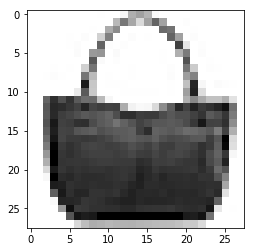

Class: 8


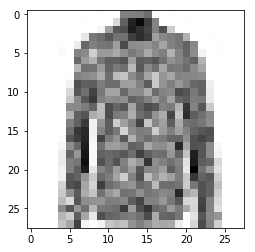

Class: 6


In [5]:
x, y = train[100]
x2, y2 = test[101]
show_torch_image(x)
print('Class:', y)

show_torch_image(x2)
print('Class:', y2)

## Now we can make dataloaders

In [6]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test,
                                          batch_size=batch_size,
                                          shuffle=True)

## Lets train that simple classifier we build in 2

In [7]:
from utils import SimpleClassifier

In [8]:
n_classes = 10
n_features = 28*28
n_examples = len(train_loader)
hidden_size = 512

model = SimpleClassifier(n_features, hidden_size, n_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [9]:
import time

n_epoch = 5
model.train()

start = time.time()

for epoch in range(1, n_epoch+1):
    total_loss = 0.0
    for i, (X, y) in enumerate(train_loader):
        # our model is expecting batches of 1D inputs
        X = Variable(X.float())
        y = Variable(y)
        
        y_hat = model(X)
        loss = criterion(y_hat, y)
        total_loss += loss.data[0]
    
        # backprop error, update weights, zero old grads
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print('Avg loss: {}'.format(total_loss / len(train_loader)))
    
print('Took {:.3f}s'.format(time.time() - start))

Avg loss: 1.8780754948298137
Avg loss: 1.8452030564626059
Avg loss: 1.8337594259262084
Avg loss: 1.8195721928278605
Avg loss: 1.8108612883885702
Took 75.268s
